In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statistics as stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import io # StringIO
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

In [4]:
multiclass = pd.read_csv("multiclass.csv")

In [5]:
# Encode attack labels to int and save as array to be used later.
le = LabelEncoder()
multiclass[" Label"] = le.fit_transform(multiclass[" Label"].values)

multiclass_labels = []
print("\nMulticlass Label Encodings (in order of digits 0 -> n): ")
for i in range(0, len(list(set(list(multiclass[' Label']))))):
    multiclass_labels.append(le.inverse_transform([i])[0])

print(multiclass_labels)


Multiclass Label Encodings (in order of digits 0 -> n): 
['DNS', 'LDAP', 'MSSQL', 'NTP', 'NetBIOS', 'SNMP', 'SSDP', 'Syn', 'TFTP', 'UDP', 'UDP-lag']


In [15]:
#xg_feat = ['Total Length of Fwd Packets',' Average Packet Size','Flow Bytes/s',' Min Packet Length', ' Max Packet Length',' Fwd Packet Length Max','Init_Win_bytes_forward',' Fwd Packet Length Min',' Fwd Packet Length Mean',' min_seg_size_forward',' Fwd Header Length',' act_data_pkt_fwd',' Flow Duration',' Packet Length Mean','label']
#df_bin = df_bin.loc[:, xg_feat]

In [6]:
y = multiclass[" Label"].copy()
X = multiclass.drop([" Label"], axis=1)

In [7]:
X_train0, X_test, y_train0, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train0, y_train0, test_size = 0.125, stratify=y_train0, random_state=42)

In [9]:
X_tr = np.reshape(X_train.to_numpy(), (len(X_train), 1, 80))
X_vl = np.reshape(X_val.to_numpy(), (len(X_val), 1, 80))
X_tst = np.reshape(X_test.to_numpy(), (len(X_test), 1, 80))

In [10]:
print(X_tr.shape)
print(y_train.shape)

(394006, 1, 80)
(394006,)


In [37]:
inputs = keras.Input(shape=(1, 80))

x = Dense(512, activation='relu')(inputs)
x = Dense(128, activation='relu')(x)
outputs = Dense(11, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='MLP_model')
model.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "MLP_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1, 80)]           0         
                                                                 
 dense_5 (Dense)             (None, 1, 512)            41472     
                                                                 
 dense_6 (Dense)             (None, 1, 128)            65664     
                                                                 
 dense_7 (Dense)             (None, 1, 11)             1419      
                                                                 
Total params: 108,555
Trainable params: 108,555
Non-trainable params: 0
_________________________________________________________________


In [15]:
normalizer = keras.layers.Normalization()
normalizer.adapt(X_train)

inputs = keras.Input(shape=(1, 80))

x = normalizer(inputs)

x = LSTM(512, activation='tanh', return_sequences=True)(x)
x = LSTM(128, activation='tanh')(x)
outputs = Dense(11, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='LSTM_model')
model.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 80)]           0         
                                                                 
 normalization_3 (Normalizat  (None, 1, 80)            161       
 ion)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 1, 512)            1214464   
                                                                 
 lstm_3 (LSTM)               (None, 128)               328192    
                                                                 
 dense_1 (Dense)             (None, 11)                1419      
                                                                 
Total params: 1,544,236
Trainable params: 1,544,075
Non-trainable params: 161
____________________________________________

In [16]:
history=model.fit(X_tr, y_train.to_numpy(), validation_data = (X_vl, y_val.to_numpy()), batch_size=128, epochs=30)

Epoch 1/30
3079/3079 [==============================] - 25s 7ms/step - loss: 0.6921 - accuracy: 0.6737 - val_loss: 0.6482 - val_accuracy: 0.6836
Epoch 2/30
3079/3079 [==============================] - 19s 6ms/step - loss: 0.6293 - accuracy: 0.6913 - val_loss: 0.6255 - val_accuracy: 0.6897
Epoch 3/30
3079/3079 [==============================] - 18s 6ms/step - loss: 0.6216 - accuracy: 0.6948 - val_loss: 0.6413 - val_accuracy: 0.6878
Epoch 4/30
3079/3079 [==============================] - 18s 6ms/step - loss: 0.6177 - accuracy: 0.6952 - val_loss: 0.6219 - val_accuracy: 0.7004
Epoch 5/30
3079/3079 [==============================] - 18s 6ms/step - loss: 0.6142 - accuracy: 0.6981 - val_loss: 0.6146 - val_accuracy: 0.6979
Epoch 6/30
3079/3079 [==============================] - 18s 6ms/step - loss: 0.6126 - accuracy: 0.6982 - val_loss: 0.6151 - val_accuracy: 0.7004
Epoch 7/30
3079/3079 [==============================] - 18s 6ms/step - loss: 0.6110 - accuracy: 0.6994 - val_loss: 0.6114 - val_ac

In [28]:
#history=model.fit(X_tr, y_train.to_numpy(), batch_size=len(X_tr), epochs=10)
path_new_model = "LSTM_mod.h5"

#Save final model
model.save(path_new_model)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


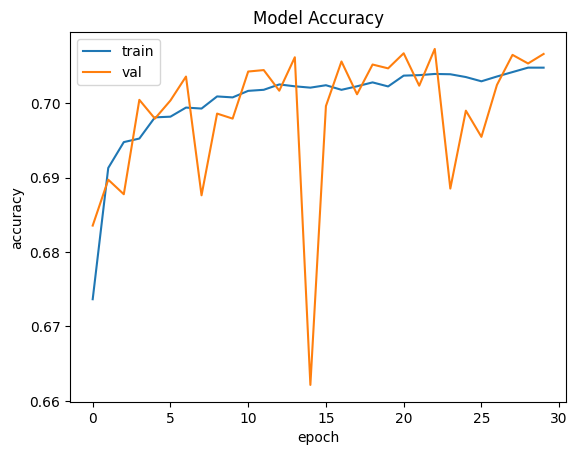

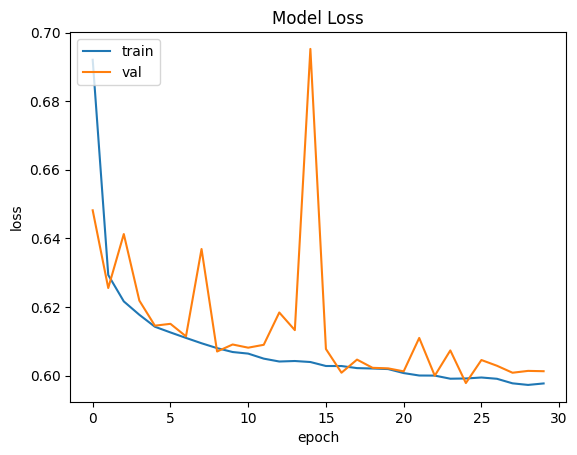

In [17]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig('/content/LSTM_binary_train.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig('/content/LSTM_binary_val.png')
plt.show()

In [19]:
#Test metrics
#test_loss, test_acc = model.evaluate(X_tst, y_test, verbose=0)
#print('Test metrics: Loss {0} Accuracy: {1}'.format(test_loss,test_acc))

#Test predictions
prediction = model.predict(X_tst)

4691/4691 [==============================] - 10s 2ms/step


In [20]:
print(prediction)

[[1.1223508e-01 2.4283518e-01 7.5748935e-03 ... 4.0057312e-06
  6.1092258e-04 3.2161782e-03]
 [1.5992309e-03 3.7500315e-06 4.2195447e-02 ... 8.4632546e-08
  4.8611587e-01 4.9810003e-02]
 [1.6764519e-04 3.2383480e-07 5.1023024e-03 ... 9.9431795e-01
  2.3474540e-04 6.8912850e-06]
 ...
 [7.5568270e-04 4.2397980e-07 2.6123254e-05 ... 2.9117162e-08
  5.3007191e-01 5.5949975e-02]
 [7.3547822e-01 1.0714712e-01 5.5070692e-03 ... 8.2133761e-07
  1.5862771e-04 7.4741438e-05]
 [2.1831307e-03 4.3038253e-06 4.2803388e-02 ... 8.5968665e-08
  4.9921185e-01 5.2230828e-02]]


In [21]:
#pred = [1 if prediction[i] >= 0.5 else 0 for i in range(len(prediction))]
pred = [np.argmax(x) for x in prediction]
pd.Series(pred).value_counts()

9     25571
7     22728
5     18335
1     16529
4     14158
2     13989
8     13681
3     13624
0      5605
6      3035
10     2843
dtype: int64

In [30]:
print(y_test.to_numpy())

[ 5 10  8 ... 10  5  6]


In [34]:
print(classification_report(y_test.to_numpy(), pred, digits=6))

              precision    recall  f1-score   support

           0   0.643533  0.264346  0.374753     13645
           1   0.495251  0.599927  0.542586     13645
           2   0.896347  0.918945  0.907505     13645
           3   0.989357  0.987762  0.988559     13646
           4   0.948157  0.983804  0.965651     13645
           5   0.625143  0.840015  0.716823     13645
           6   0.494563  0.109996  0.179965     13646
           7   0.599613  0.998681  0.749326     13646
           8   0.989986  0.992598  0.991290     13645
           9   0.473818  0.887944  0.617911     13645
          10   0.953922  0.198754  0.328967     13645

    accuracy                       0.707524    150098
   macro avg   0.737244  0.707525  0.669394    150098
weighted avg   0.737244  0.707524  0.669394    150098



[[ 3607  7063   503    39   129  2184    21     1     1    88     9]
 [ 1340  8186   134     3     0  3980     1     1     0     0     0]
 [   47   206 12539    58     0   293    46     0   128   327     1]
 [   95     0    35 13479    21     0     1     0     0     2    13]
 [   39     2   155     2 13424     4     2     0     3    13     1]
 [  439  1061    96     5   574 11462     5     0     0     1     2]
 [   20     2   303    12     7   192  1501     0     2 11565    42]
 [    0     0     0     0     1     0     0 13628     0     0    17]
 [    2     0     1     3     1     1     0    91 13544     0     2]
 [   14     3   214     9     1    11  1229     1     3 12116    44]
 [    2     6     9    14     0   208   229  9006     0  1459  2712]]


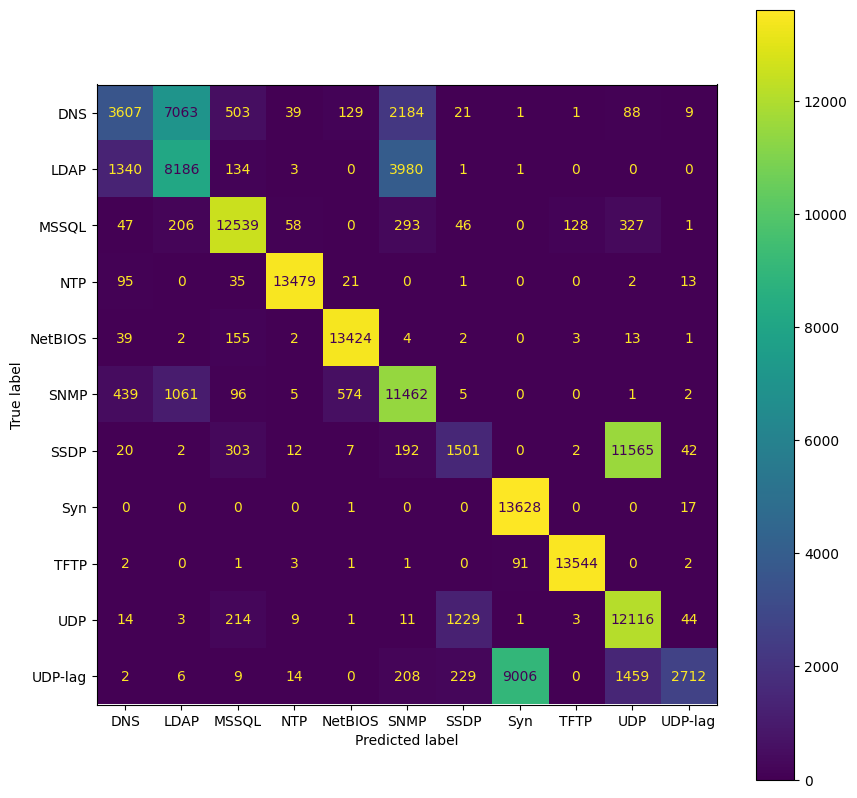

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=multiclass_labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
#plt.savefig('/content/LSTM_binary_test_ConfusionMatrix.png')
print(cm)
#plt.show()
plt.savefig("confusion.png")